In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.datasets import load_boston, load_diabetes
from sklearn import exceptions

from tqdm.auto import tqdm

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [ ]:
# X, y = load_boston(True)
X, y = load_diabetes(True)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=.8, test_size=.2)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_valid = scaler.transform(X_valid)

## Cross Validation

In [ ]:
reg = make_pipeline(
    StandardScaler(), 
    SGDRegressor(max_iter=1000, tol=1e-3)
    )

In [ ]:
cross_validate(
    estimator=reg, 
    X=X, 
    y=y, 
    cv=5, 
    scoring=make_scorer(root_mean_squared_error),
    return_train_score=True, 
    return_estimator=False)

{'fit_time': array([0.00605202, 0.0024693 , 0.00248671, 0.00212502, 0.00232959]),
 'score_time': array([0.00084472, 0.00055218, 0.00050259, 0.0007093 , 0.00056076]),
 'test_score': array([53.15847518, 55.35744133, 56.44444847, 55.06476443, 54.40072339]),
 'train_score': array([54.04448963, 53.39517948, 53.09552963, 53.62770306, 53.50288448])}

## Online Learning

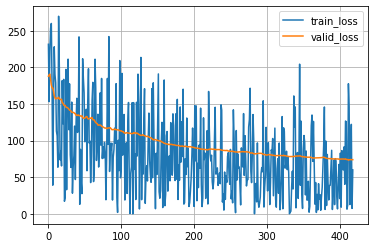

In [ ]:
sgd = SGDRegressor()

train_loss = []
valid_loss = []

scores = []
exp_scores = []
running_mae = 0
exp_mae = 0

zipped_X_y = zip(scaled_X_train, y_train)

for i, (X_chunk, y_chunk) in tqdm(enumerate(zipped_X_y, start= 1)):
    try:
        y_pred = sgd.predict([X_chunk])[0]
    except exceptions.NotFittedError: 
        y_pred = 0.

    mae = abs(y_pred - y_chunk)

    # Update the running mean absolute error
    running_mae += (mae - running_mae) / i

    # Update the exponential moving average of the MAE
    exp_mae = .1 * mae + .9 * exp_mae

    sgd.partial_fit([X_chunk], [y_chunk])

    train_loss.append(mean_squared_error([y_chunk], sgd.predict([X_chunk]), squared=False))
    valid_loss.append(mean_squared_error(y_valid, sgd.predict(scaled_X_valid), squared=False))

    scores.append(running_mae)
    exp_scores.append(exp_mae)

sns.lineplot(x=np.arange(len(train_loss)), y=train_loss, label='train_loss')
sns.lineplot(x=np.arange(len(valid_loss)), y=valid_loss, label='valid_loss')
plt.grid(True)
plt.show()

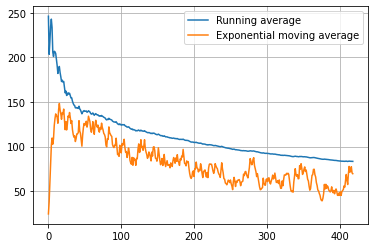

In [ ]:
sns.lineplot(x=np.arange(len(scores)), y=scores, label='Running average')
sns.lineplot(x=np.arange(len(exp_scores)), y=exp_scores, label='Exponential moving average')
plt.grid(True)
plt.show()

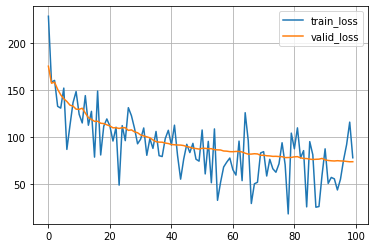

In [ ]:
n_split = 100
X_chunks = np.array_split(scaled_X_train, n_split)
y_chunks = np.array_split(y_train, n_split)

sgd = SGDRegressor()

train_loss = []
valid_loss = []

for X_chunk, y_chunk in tqdm(zip(X_chunks, y_chunks)):
    sgd.partial_fit(X_chunk, y_chunk)

    train_loss.append(mean_squared_error(y_chunk, sgd.predict(X_chunk), squared=False))
    valid_loss.append(mean_squared_error(y_valid, sgd.predict(scaled_X_valid), squared=False))

sns.lineplot(x=np.arange(len(train_loss)), y=train_loss, label='train_loss')
sns.lineplot(x=np.arange(len(valid_loss)), y=valid_loss, label='valid_loss')
plt.grid(True)
plt.show()

## Offline Learning

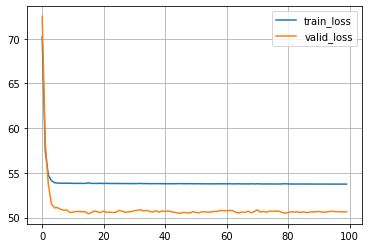

In [ ]:
sgd = SGDRegressor()

epochs = 100

train_loss = []
valid_loss = []

for _ in tqdm(range(epochs)):
    sgd.partial_fit(scaled_X_train, y_train)

    train_loss.append(mean_squared_error(y_train, sgd.predict(scaled_X_train), squared=False))
    valid_loss.append(mean_squared_error(y_valid, sgd.predict(scaled_X_valid), squared=False))

sns.lineplot(x=np.arange(epochs), y=train_loss, label='train_loss')
sns.lineplot(x=np.arange(epochs), y=valid_loss, label='valid_loss')
plt.grid(True)
plt.show()